In [1]:
import numpy as np
import math
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import sys
import os
import pandas as pd
import matplotlib.patches as mpatches
%matplotlib inline



# Global Parameters

In [2]:
# mycolor
pytorch    = '#136aa8'
tensorflow = '#ff7527'
mycolors   = [pytorch, tensorflow]

# working dirs
datadir = "/global/cfs/cdirs/m1759/yswang/results"

# keys
selectkeys = ['Name', 'Invocations', 'CUDA Time', 'Performance GFlop/s', 'FLOPs', 'L1 AI', 'L2 AI', 'DRAM AI', 'L1 Bytes', 'L2 Bytes', 'DRAM Bytes']

# Load Data

In [3]:
tfcombineddf = pd.read_csv(os.path.join(datadir,"tf_combined_profile.csv"))
ptcombineddf = pd.read_csv(os.path.join(datadir,"pt_combined_profile.csv"))
tfprofiledf  = pd.read_csv(os.path.join(datadir,"tf_full_profile.csv"))
ptprofiledf  = pd.read_csv(os.path.join(datadir,"pt_full_profile.csv"))

# PyTorch vs. Tensorflow (FW + BW)

## Overview
* Total number of FLOPs are similar
* PT has ~2x more data movement at each memory level
* PT has 3.5x more invocations
* PT is 3.5x slower

In [4]:
tfcombineddf['Name'] = 'Tensorflow'
tfdf = tfcombineddf[selectkeys]

ptcombineddf['Name'] = 'PyTorch'
ptcombineddf = ptcombineddf.groupby(['Name']).sum().reset_index()
ptdf = ptcombineddf[selectkeys].copy()
ptdf['Performance GFlop/s'] = ptdf['FLOPs'] / ptdf['CUDA Time'] / 1e9
ptdf['L1 AI'] = ptdf['FLOPs'] / ptdf['L1 Bytes']
ptdf['L2 AI'] = ptdf['FLOPs'] / ptdf['L2 Bytes']
ptdf['DRAM AI'] = ptdf['FLOPs'] / ptdf['DRAM Bytes']

combineddf = ptdf.append(tfdf).reset_index(drop=True)

display(combineddf)

,Name,Invocations,CUDA Time,Performance GFlop/s,FLOPs,L1 AI,L2 AI,DRAM AI,L1 Bytes,L2 Bytes,DRAM Bytes
0,PyTorch,13918,1.965224,17748.450629,3.487967e+13,14.915387,39.475104,95.653850,2.338503e+12,8.835866e+11,3.646448e+11
1,Tensorflow,3979,0.562614,61473.929130,3.458606e+13,30.374284,72.801114,235.200928,1.138663e+12,4.750760e+11,1.470490e+11


## Detailed comparison

In [5]:
ptdf = ptprofiledf[selectkeys].copy()
ptdf = ptdf.groupby(['Name']).sum().sort_values('CUDA Time', ascending=False)
ptdf.reset_index(inplace=True)
ptdf['Performance GFlop/s'] = ptdf['FLOPs'] / ptdf['CUDA Time'] / 1e9
ptdf['L1 AI'] = ptdf['FLOPs'] / ptdf['L1 Bytes']
ptdf['L2 AI'] = ptdf['FLOPs'] / ptdf['L2 Bytes']
ptdf['DRAM AI'] = ptdf['FLOPs'] / ptdf['DRAM Bytes']

#profiledf = profiledf.sort_values('CUDA Time', ascending=False).reset_index(drop=True)
tfdf = tfprofiledf[selectkeys].copy()

# print
display(ptdf)
display(tfdf)

,Name,Invocations,CUDA Time,Performance GFlop/s,FLOPs,L1 AI,L2 AI,DRAM AI,L1 Bytes,L2 Bytes,DRAM Bytes
0,"void dgrad2d_grouped_direct_kernel<__half, flo...",6,0.389369,1256.672100,4.893086e+11,1.017664,4.801972,1685.952435,4.808152e+11,1.018974e+11,2.902268e+08
1,void cudnn::detail::implicit_convolve_sgemm<__...,18,0.142568,8247.785594,1.175874e+12,8.528240,32.412751,1057.435597,1.378801e+11,3.627814e+10,1.112006e+09
2,"void cudnn::detail::wgrad_alg1_engine<__half, ...",18,0.109882,10703.258549,1.176097e+12,6.654175,42.190791,448.438015,1.767458e+11,2.787569e+10,2.622653e+09
3,"void at::native::col2im_kernel<c10::Half, floa...",48,0.099744,41.514484,4.140818e+09,0.558044,0.685239,0.701017,7.420241e+09,6.042879e+09,5.906872e+09
4,"void nchwToNhwcKernel<__half, __half, float, t...",1440,0.091944,279.121250,2.566359e+10,0.283289,0.464073,0.517792,9.059166e+10,5.530071e+10,4.956354e+10
...,...,...,...,...,...,...,...,...,...,...,...
99,cask_cudnn::computeBOffsetsKernel(cask_cudnn::...,12,0.000043,0.000000,0.000000e+00,0.000000,0.000000,0.000000,1.536000e+03,5.145600e+04,4.070400e+04
100,void at::native::legacy::elementwise_kernel<12...,6,0.000021,0.000000,0.000000e+00,0.000000,0.000000,0.000000,1.920000e+02,3.872000e+04,3.379200e+04
101,cudnn::gemm::computeWgradBOffsetsKernel(cudnn:...,6,0.000020,0.000000,0.000000e+00,0.000000,0.000000,0.000000,7.680000e+02,2.419200e+04,1.862400e+04
102,cudnn::gemm::computeWgradSplitKOffsetsKernel(c...,6,0.000019,0.000000,0.000000e+00,0.000000,0.000000,0.000000,7.680000e+02,2.419200e+04,1.824000e+04


,Name,Invocations,CUDA Time,Performance GFlop/s,FLOPs,L1 AI,L2 AI,DRAM AI,L1 Bytes,L2 Bytes,DRAM Bytes
0,volta_fp16_s884cudnn_fp16_128x128_ldg8_dgrad_f...,23,0.103089,101743.237841,1.048857e+13,32.081803,79.728013,679.212909,3.269319e+11,1.315543e+11,1.544223e+10
1,volta_s884cudnn_fp16_256x128_ldg8_wgrad_idx_ex...,11,0.080036,112105.643643,8.972508e+12,43.438656,120.230174,733.867424,2.065558e+11,7.462775e+10,1.222633e+10
2,Volta_hmma_implicit_gemm_fprop_fp32_nhwc_128x1...,8,0.065804,92787.257420,6.105808e+12,30.295081,94.034679,1039.078329,2.015445e+11,6.493144e+10,5.876176e+09
3,void tensorflow::functor::PadInputCustomKernel...,9,0.028846,0.000000,0.000000e+00,0.000000,0.000000,0.000000,7.150988e+09,7.141509e+09,7.150892e+09
4,void tensorflow::BiasNHWCKernel<Eigen::half>(i...,28,0.028680,85.635644,2.456027e+09,0.166667,0.249928,0.249384,1.473615e+10,9.826943e+09,9.848376e+09
...,...,...,...,...,...,...,...,...,...,...,...
95,volta_fp16_sgemm_fp16_128x32_nt,1,0.000010,887.026438,8.912896e+06,2.101876,8.031373,6.160352,4.240448e+06,1.109760e+06,1.446816e+06
96,void Eigen::internal::EigenMetaKernel<Eigen::T...,2,0.000010,0.001031,1.000000e+01,0.078125,0.003765,0.002741,1.280000e+02,2.656000e+03,3.648000e+03
97,void tensorflow::_GLOBAL__N__69_tmpxft_0000501...,1,0.000006,0.000000,0.000000e+00,0.000000,0.000000,0.000000,2.374400e+04,2.134400e+04,3.910400e+04
98,void Eigen::internal::EigenMetaKernel<Eigen::T...,1,0.000004,0.000000,0.000000e+00,0.000000,0.000000,0.000000,9.600000e+01,1.376000e+03,1.600000e+03


### Top 5 kernels

In [6]:
topN = 5

# get top5 kernels
top_tfdf = tfdf.head(topN).copy()
top_ptdf = ptdf.head(topN).copy()

# insert total runtime
tf_runtime = tfdf['CUDA Time'].sum()
pt_runtime = ptdf['CUDA Time'].sum()
top_tfdf['Total Time'] = tf_runtime
top_ptdf['Total Time'] = pt_runtime
# insert total FLOPs
tf_flops = tfdf['FLOPs'].sum()
pt_flops = ptdf['FLOPs'].sum()
top_tfdf['Total FLOPs'] = tf_flops
top_ptdf['Total FLOPs'] = pt_flops
# insert total bytes
tf_bytes = tfdf['DRAM Bytes'].sum()
pt_bytes = ptdf['DRAM Bytes'].sum()
top_tfdf['Total Bytes'] = tf_bytes
top_ptdf['Total Bytes'] = pt_bytes
# insert total invocations
tf_calls = tfdf['Invocations'].sum()
pt_calls = ptdf['Invocations'].sum()
top_tfdf['Total Invocations'] = tf_calls
top_ptdf['Total Invocations'] = pt_calls

top_tfdf['Name'] = 'Tensorflow'
top_ptdf['Name'] = 'PyTorch'

# merge
topdf = top_tfdf.append(top_ptdf)
topdf = topdf.groupby(['Name', 'Total Time', 'Total FLOPs', 'Total Bytes', 'Total Invocations']).sum().reset_index()

# recalculate AI and FLOP rates
topdf['Performance GFlop/s'] = topdf['FLOPs'] / topdf['CUDA Time'] /1e9
topdf['DRAM AI'] = topdf['FLOPs'] / topdf['DRAM Bytes']
topdf['% of overall runtime'] = topdf['CUDA Time'] / topdf['Total Time']*100
topdf['% of overall FLOPs'] = topdf['FLOPs'] / topdf['Total FLOPs']*100
topdf['% of overall bytes'] = topdf['DRAM Bytes'] / topdf['Total Bytes']*100
topdf['% of invocations'] = topdf['Invocations'] / topdf['Total Invocations']*100

# cleanups
del topdf['Total Time']
del topdf['Total FLOPs']
del topdf['Total Bytes']
#del topdf['CUDA Time']

#### Top 5 kernels: results
* PyTorch: 9x less FLOPs with the same amount of data transfer
* Tensorflow: top 5 kernels take 74% overall FLOPs
* PyTorch's runtime: 2.77x longer than Tensorflow

In [7]:
# print
display(topdf)

,Name,Total Invocations,Invocations,CUDA Time,Performance GFlop/s,FLOPs,L1 AI,L2 AI,DRAM AI,L1 Bytes,L2 Bytes,DRAM Bytes,% of overall runtime,% of overall FLOPs,% of overall bytes,% of invocations
0,PyTorch,13918,1530,0.833507,3444.582128,2.871085e+12,17.041412,80.554827,48.257338,8.934530e+11,2.273948e+11,5.949529e+10,42.412851,8.231397,16.315961,10.992959
1,Tensorflow,3979,79,0.306455,83435.964458,2.556934e+13,105.982206,294.242794,505.882595,7.569194e+11,2.880820e+11,5.054401e+10,54.469827,73.929593,34.372222,1.985423


### Mutual kernels
* Different algorithms calling same kernels (FLOPs/Bytes are so different)
* 9 common kernels out of 100-ish kernels in total

In [8]:
tmpdf = tfdf.merge(ptdf, on='Name', how='inner')
tmpdf.columns = tmpdf.columns.str.replace('_x',' (PT)')
tmpdf.columns = tmpdf.columns.str.replace('_y',' (TF)')
display(tmpdf)

,Name,Invocations (PT),CUDA Time (PT),Performance GFlop/s (PT),FLOPs (PT),L1 AI (PT),L2 AI (PT),DRAM AI (PT),L1 Bytes (PT),L2 Bytes (PT),...,Invocations (TF),CUDA Time (TF),Performance GFlop/s (TF),FLOPs (TF),L1 AI (TF),L2 AI (TF),DRAM AI (TF),L1 Bytes (TF),L2 Bytes (TF),DRAM Bytes (TF)
0,Volta_hmma_implicit_gemm_fprop_fp32_nhwc_128x1...,8,0.065804,92787.257420,6.105808e+12,30.295081,94.034679,1039.078329,2.015445e+11,6.493144e+10,...,12,0.021563,97460.747863,2.101531e+12,33.129705,97.819241,1303.492971,6.343343e+10,2.148382e+10,1.612230e+09
1,volta_fp16_s884gemm_fp16_128x128_ldg8_f2f_nt,15,0.004711,87610.731038,4.127712e+11,40.743575,91.255202,355.385573,1.013095e+10,4.523262e+09,...,36,0.015462,76080.596863,1.176324e+12,25.530540,59.260937,226.962966,4.607517e+10,1.984990e+10,5.182889e+09
2,volta_fp16_s884gemm_fp16_128x256_ldg8_f2f_tn,3,0.002220,103636.864840,2.301230e+11,42.893815,108.375386,492.834845,5.364946e+09,2.123388e+09,...,24,0.015451,84057.041947,1.298760e+12,44.188879,110.827986,300.781883,2.939111e+10,1.171870e+10,4.317947e+09
3,Volta_hmma_implicit_gemm_wgrad_fp32_nhwc_64x32...,1,0.001874,44613.075086,8.359203e+10,17.391316,33.571387,63.806893,4.806538e+09,2.489978e+09,...,6,0.002982,41772.848420,1.245616e+11,15.453201,27.590444,81.664264,8.060570e+09,4.514665e+09,1.525289e+09
4,volta_fp16_s884gemm_fp16_256x128_ldg8_f2f_nn,3,0.001821,105437.059180,1.920275e+11,42.527066,108.521380,434.196258,4.515417e+09,1.769490e+09,...,36,0.014497,91366.123435,1.324575e+12,40.675657,102.812874,247.545784,3.256431e+10,1.288335e+10,5.350826e+09
5,Volta_hmma_implicit_gemm_wgrad_fp32_nhwc_128x1...,4,0.000686,76420.444810,5.245249e+10,43.651971,96.947229,737.110073,1.201607e+09,5.410417e+08,...,6,0.012022,84077.218867,1.010772e+12,57.060760,421.080156,1362.422128,1.771396e+10,2.400426e+09,7.418933e+08
6,cudnn::gemm::computeOffsetsKernel(cudnn::gemm:...,45,0.000234,0.000000,0.000000e+00,0.000000,0.000000,0.000000,3.897338e+07,3.942080e+07,...,858,0.002810,0.000000,0.000000e+00,0.000000,0.000000,0.000000,9.778963e+07,1.113420e+08,3.034752e+06
7,cudnn::gemm::computeBOffsetsKernel(cudnn::gemm...,26,0.000087,0.000000,0.000000e+00,0.000000,0.000000,0.000000,6.662400e+04,9.385600e+04,...,426,0.001311,0.000000,0.000000e+00,0.000000,0.000000,0.000000,1.119168e+06,2.668288e+06,1.208352e+06
8,volta_fp16_sgemm_fp16_128x32_nt,1,0.000010,887.026438,8.912896e+06,2.101876,8.031373,6.160352,4.240448e+06,1.109760e+06,...,12,0.003614,12054.988045,4.357148e+10,5.082549,26.051070,29.308326,8.572762e+09,1.672541e+09,1.486659e+09


### Time & DRAM AI

Tensorflow AI : 0.0 - 1039.07833
PyTorch AI    : 0.0 - 1685.95244


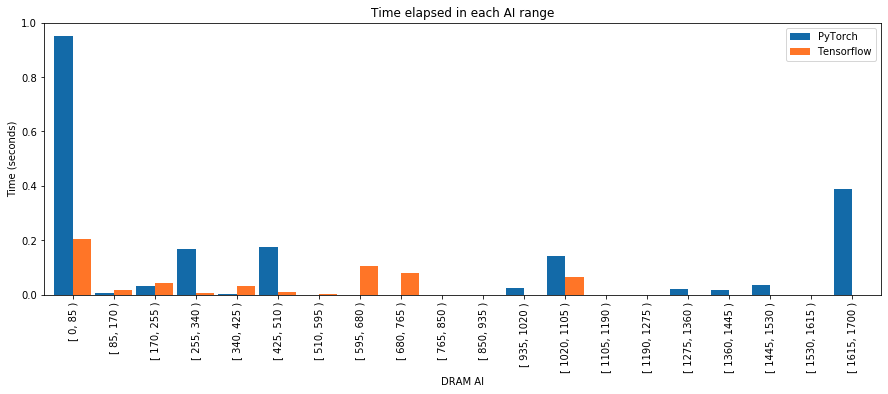

In [9]:
# AI range
ltfai = list(tfdf['DRAM AI'])
lptai = list(ptdf['DRAM AI'])
print('Tensorflow AI : {} - {:.5f}'.format(min(ltfai), max(ltfai)))
print('PyTorch AI    : {} - {:.5f}'.format(min(lptai), max(lptai)))

min_ai = 0.
max_ai = 1700.

# hist parameters
N = 20
stride = (max_ai - min_ai) / N

lhistid = []
lai     = []

for i in range(N):
    lhistid.append(i)
    airange = '[ ' + str(int(i * stride)) + ', ' + str(int((i+1) * stride)) + ' )'
    lai.append(airange)

resdf = pd.DataFrame({'Hist ID': lhistid, 'AI': lai})

def ai_classifier(row):
    res = '[ ' + str(int(row['DRAM AI'] / stride)*int(stride))\
          + ', ' + str(int(row['DRAM AI'] / stride + 1)*int(stride)) + ' )'
    return res

def hist_classifier(row):
    return int(row['DRAM AI'] / stride)
    
tfdf['AI'] = tfdf.apply(ai_classifier, axis=1)
ptdf['AI'] = ptdf.apply(ai_classifier, axis=1)
tfdf['Hist ID'] = tfdf.apply(hist_classifier, axis=1)
ptdf['Hist ID'] = ptdf.apply(hist_classifier, axis=1)

tmptf = tfdf.groupby(['Hist ID', 'AI']).sum().reset_index()
tmppt = ptdf.groupby(['Hist ID', 'AI']).sum().reset_index()

tmptf = tmptf.merge(tmppt, on=['Hist ID', 'AI'], how='outer')
resdf = resdf.merge(tmptf, on=['Hist ID', 'AI'], how='outer')
resdf = resdf[['Hist ID', 'AI', 'CUDA Time_x', 'CUDA Time_y']].fillna(0.).rename(columns={"CUDA Time_x": 'Tensorflow', 'CUDA Time_y': 'PyTorch'}).sort_values('Hist ID')
#display(resdf)

ax = resdf.plot.bar(x='AI', y=['PyTorch', 'Tensorflow'], figsize=(15, 5), title='Time elapsed in each AI range', width=0.9, color=mycolors)
ax = ax.set(xlabel='DRAM AI', ylabel='Time (seconds)')

### Time & FLOP Rates

Tensorflow GFLOPs/s : 0.0 - 112105.64364
PyTorch GFLOPs/s    : 0.0 - 103288.79266


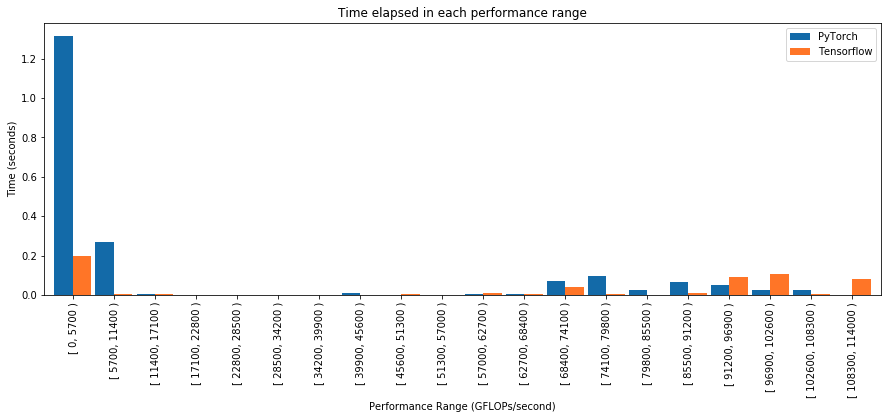

In [10]:
# AI range
ltfflops = list(tfdf['Performance GFlop/s'])
lptflops = list(ptdf['Performance GFlop/s'])
print('Tensorflow GFLOPs/s : {} - {:.5f}'.format(min(ltfflops), max(ltfflops)))
print('PyTorch GFLOPs/s    : {} - {:.5f}'.format(min(lptflops), max(lptflops)))

min_gflops = 0.
max_gflops = 114000.

# hist parameters
N = 20
stride = (max_gflops - min_gflops) / N

lhistid = []
lflops  = []

for i in range(N):
    lhistid.append(i)
    floprange = '[ ' + str(int(i * stride)) + ', ' + str(int((i+1) * stride)) + ' )'
    lflops.append(floprange)

resdf = pd.DataFrame({'Hist ID': lhistid, 'Perf': lflops})

def flop_classifier(row):
    res = '[ ' + str(int(row['Performance GFlop/s'] / (stride))*int(stride))\
          + ', ' + str(int(row['Performance GFlop/s'] / (stride) + 1)*int(stride)) + ' )'
    return res

def hist_classifier(row):
    return int(row['Performance GFlop/s'] / stride)
    
tfdf['Perf'] = tfdf.apply(flop_classifier, axis=1)
ptdf['Perf'] = ptdf.apply(flop_classifier, axis=1)

tfdf['Hist ID'] = tfdf.apply(hist_classifier, axis=1)
ptdf['Hist ID'] = ptdf.apply(hist_classifier, axis=1)

tmptf = tfdf.groupby(['Hist ID', 'Perf']).sum().reset_index()
tmppt = ptdf.groupby(['Hist ID', 'Perf']).sum().reset_index()

tmptf = tmptf.merge(tmppt, on=['Hist ID', 'Perf'], how='outer')
resdf = resdf.merge(tmptf, on=['Hist ID', 'Perf'], how='outer')
resdf = resdf[['Hist ID', 'Perf', 'CUDA Time_x', 'CUDA Time_y']].fillna(0.).rename(columns={"CUDA Time_x": 'Tensorflow', 'CUDA Time_y': 'PyTorch'}).sort_values('Hist ID')
#display(resdf)

ax = resdf.plot.bar(x='Perf', y=['PyTorch', 'Tensorflow'], figsize=(15, 5), title='Time elapsed in each performance range', width=0.9, color=mycolors)
ax = ax.set(xlabel='Performance Range (GFLOPs/second)', ylabel='Time (seconds)')

### Time & #FLOPs

Tensorflow GFLOPs : 0.0 - 10488.56509
PyTorch GFLOPs    : 0.0 - 6093.07166


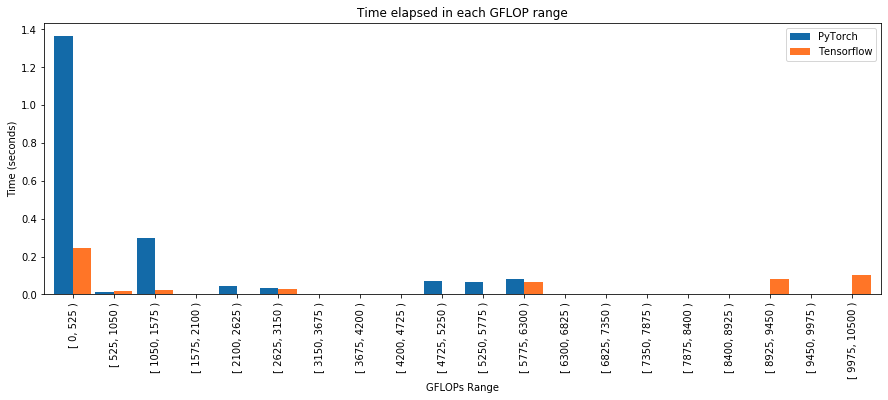

In [11]:
# AI range
ltfflops = list(tfdf['FLOPs'] / 1e9)
lptflops = list(ptdf['FLOPs'] / 1e9)
print('Tensorflow GFLOPs : {} - {:.5f}'.format(min(ltfflops), max(ltfflops)))
print('PyTorch GFLOPs    : {} - {:.5f}'.format(min(lptflops), max(lptflops)))

min_gflops = 0.
max_gflops = 10500.

# hist parameters
N = 20
stride = (max_gflops - min_gflops) / N

lhistid = []
lflops  = []

for i in range(N):
    lhistid.append(i)
    floprange = '[ ' + str(int(i * stride)) + ', ' + str(int((i+1) * stride)) + ' )'
    lflops.append(floprange)

resdf = pd.DataFrame({'Hist ID': lhistid, 'GFLOPs': lflops})

def flop_classifier(row):
    res = '[ ' + str(int(row['FLOPs'] / (stride * 1e9))*int(stride))\
          + ', ' + str(int(row['FLOPs'] / (stride * 1e9) + 1)*int(stride)) + ' )'
    return res

def hist_classifier(row):
    return int(row['FLOPs'] / stride / 1e9)
    
tfdf['GFLOPs'] = tfdf.apply(flop_classifier, axis=1)
ptdf['GFLOPs'] = ptdf.apply(flop_classifier, axis=1)

tfdf['Hist ID'] = tfdf.apply(hist_classifier, axis=1)
ptdf['Hist ID'] = ptdf.apply(hist_classifier, axis=1)

tmptf = tfdf.groupby(['Hist ID', 'GFLOPs']).sum().reset_index()
tmppt = ptdf.groupby(['Hist ID', 'GFLOPs']).sum().reset_index()

tmptf = tmptf.merge(tmppt, on=['Hist ID', 'GFLOPs'], how='outer')
resdf = resdf.merge(tmptf, on=['Hist ID', 'GFLOPs'], how='outer')
resdf = resdf[['Hist ID', 'GFLOPs', 'CUDA Time_x', 'CUDA Time_y']].fillna(0.).rename(columns={"CUDA Time_x": 'Tensorflow', 'CUDA Time_y': 'PyTorch'}).sort_values('Hist ID')
#display(resdf)

ax = resdf.plot.bar(x='GFLOPs', y=['PyTorch', 'Tensorflow'], figsize=(15, 5), title='Time elapsed in each GFLOP range', width=0.9, color=mycolors)
ax = ax.set(xlabel='GFLOPs Range', ylabel='Time (seconds)')